In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

# Data Preparation

In [ ]:
train_path = '/content/drive/MyDrive/train.pkl'
test_path = '/content/drive/MyDrive/test.pkl'

df = pd.read_pickle(train_path)
df_test = pd.read_pickle(test_path)

In [ ]:
# Select a city
city = 'Patna'
df_city = df.xs(city, level='city').drop(['Longitude', 'Latitude'], axis=1)

# Dataset

In [ ]:
df_city = df_city[['PM2.5_target', 'PM2.5', 'CO', 'NO', 'AT', 'Ozone', 'WS']]

In [ ]:
# Select train data and validation data
train_start_date = '2019-01-01'

idx = pd.IndexSlice
df_train =df_city.loc[idx[train_start_date:,]]

In [ ]:
for column in df_city.columns:

    df_city[column].replace({np.nan: np.mean(df_city[column])}, inplace=True)


In [ ]:
class CityDataset(Dataset):
    # We could also define our constructor to take a pandas dataframe and extract the
    # features / targets directly. Notice that we must also specify a sequence length
    def __init__(self, X, y, seq_len):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        self.seq_len = seq_len

    def __len__(self):
        return self.y.shape[0] - self.seq_len

    def __getitem__(self, idx):
        return self.X[idx:idx+self.seq_len], self.y[idx:idx+self.seq_len]

In [ ]:
# Create the dataset based on our training data
dataset = CityDataset(
    X=df_train.drop("PM2.5_target", axis=1).values,
    y=df_train[["PM2.5_target"]].values,
    seq_len=24
)

# Create a dataloader, loading 32 batches of sequences at a time
dataloader = DataLoader(dataset, batch_size=32)

In [ ]:
# Look at how one single batch looks like...
for x, y in dataloader:
    print("First Batch:")
    print(f" X shape: {x.shape}")
    print(f" Y shape: {y.shape}")
    break

First Batch:
 X shape: torch.Size([32, 24, 6])
 Y shape: torch.Size([32, 24, 1])


# Gated Recurrent Unit (GRU)

In [ ]:
# Create a recurrent network
class MyRNN(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden):
        super().__init__()
        # Use a Gated Recurrent Unit (beware of the batch_first parameter!)
        self.rnn = nn.GRU(n_inputs, n_hidden, batch_first=True)
        self.linear = nn.Linear(n_hidden, n_outputs)

    # Define the forward pass to remove the hidden state from the output
    def forward(self, x):
        # Apply the RNN
        x, _ = self.rnn(x) # (output, hidden state), discard the hidden state
        # Apply the linear layer
        x = self.linear(x)
        return x

In [ ]:
# Use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate an RNN with num_features inputs, 1 output and 32 hidden nodes
num_features = len(df_train.drop("PM2.5_target", axis=1).columns)
gru = MyRNN(num_features, 1, 32).to(device)

# Use mean-square error as a loss
loss_fn = nn.MSELoss()

In [ ]:
# Notice that the typical training structure doesn't change
n_epochs = 50
losses = np.zeros(n_epochs)

# Instantiate Adam optimizer with learning rate 0.0001
opt = optim.Adam(gru.parameters(), lr=1e-3)

gru.train()
for epoch in tqdm(range(n_epochs), desc="Training Network...", unit="epoch"):
    # Within each epoch, we iterate over the batches
    for X, y in dataloader:
        # Pass the batch to the GPU
        X = X.to(device)
        y = y.to(device)

        # Reset the gradients
        opt.zero_grad()

        # Compute the forward pass
        y_pred = gru(X)

        # Compute the loss
        loss = loss_fn(y, y_pred)

        # Compute the gradients
        loss.backward()

        # Update the parameters
        opt.step()

        # Store the epoch average losses to plot later on
        losses[epoch] += loss.detach().cpu().numpy() / y.shape[0]

Training Network...: 100%|██████████| 50/50 [07:58<00:00,  9.56s/epoch]


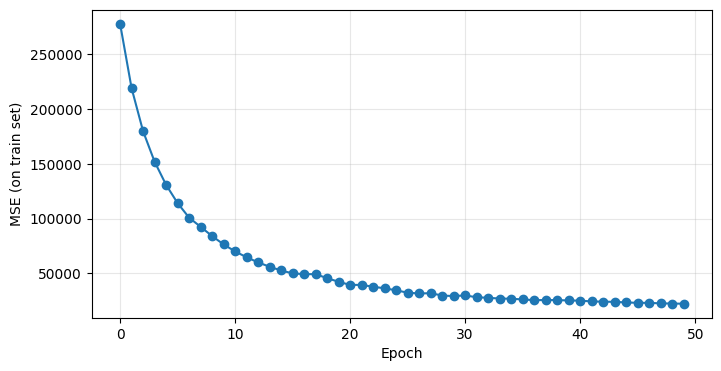

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(losses, "-o")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE (on train set)")
ax.grid(alpha=.3)

# Make predictions

In [ ]:
features_to_remove = list(set(df_test.columns) - set(df_train.columns))
df_test = df_test.xs(city, level='city').drop(features_to_remove, axis=1)
df_test.replace({np.nan: 0}, inplace=True)

In [ ]:
predictions = [df_train.loc['2021-12-31 23:00:00']['PM2.5_target'], ]

X = df_test.values

gru.eval()

for i in range(1, len(X)):

    x = torch.Tensor([predictions[-1], *X[i]]).to(device).reshape(1, 1, -1)
    prediction = gru(x).detach().cpu().item()

    predictions.append(prediction)

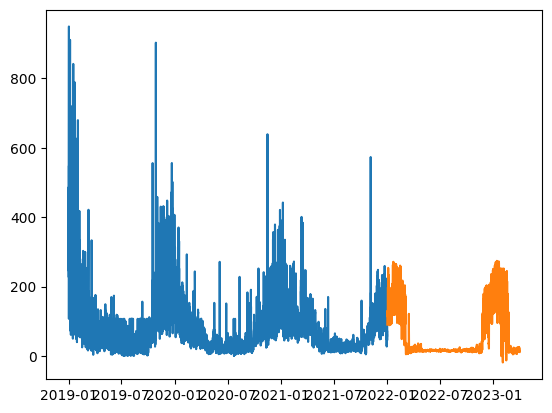

In [ ]:
plt.figure()
plt.plot(df_train['PM2.5_target'])
plt.plot(df_test.index.get_level_values('date'), predictions)

In [ ]:
predictions = np.array(predictions)

In [ ]:
predictions[predictions<0] = predictions.mean()

In [ ]:
dates = df_test.index.values
cities = [city for i in range(len(dates))]

tuples = list(zip(dates, cities))

index = pd.MultiIndex.from_tuples(tuples, names=["date", "city"])

final = pd.DataFrame(predictions, index)

In [ ]:
final

,,0
date,city,
2022-01-01 00:00:00,Patna,90.468000
2022-01-01 01:00:00,Patna,111.576309
2022-01-01 02:00:00,Patna,123.908844
2022-01-01 03:00:00,Patna,128.418823
2022-01-01 04:00:00,Patna,129.976547
...,...,...
2023-03-31 18:00:00,Patna,15.075619
2023-03-31 19:00:00,Patna,14.321933
2023-03-31 20:00:00,Patna,13.727494


In [ ]:
# final.to_pickle("/content/drive/MyDrive/{}.pickle".format(city))

In [ ]:
# df_test = pd.read_pickle(test_path)

# cities = df_test.index.get_level_values('city').unique()

# submission = pd.DataFrame()
# for x in cities:

#     preds = pd.read_pickle("/content/drive/MyDrive/{}.pickle".format(x))

#     submission = pd.concat([submission, preds], axis=0)

# submission.reindex(df_test.index).to_csv('/content/drive/MyDrive/submssion.csv')

# Our Predictions

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [ ]:
train_path = '/content/drive/MyDrive/train.pkl'
test_path = '/content/drive/MyDrive/test.pkl'

df = pd.read_pickle(train_path)
df_test = pd.read_pickle(test_path)
submission = pd.read_csv('/content/drive/MyDrive/submssion.csv', names=['date', 'city', 'PM2.5']).set_index(['date', 'city'])

<ipython-input-12-82ec2b05dbe0>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticklabels(), rotation=45)


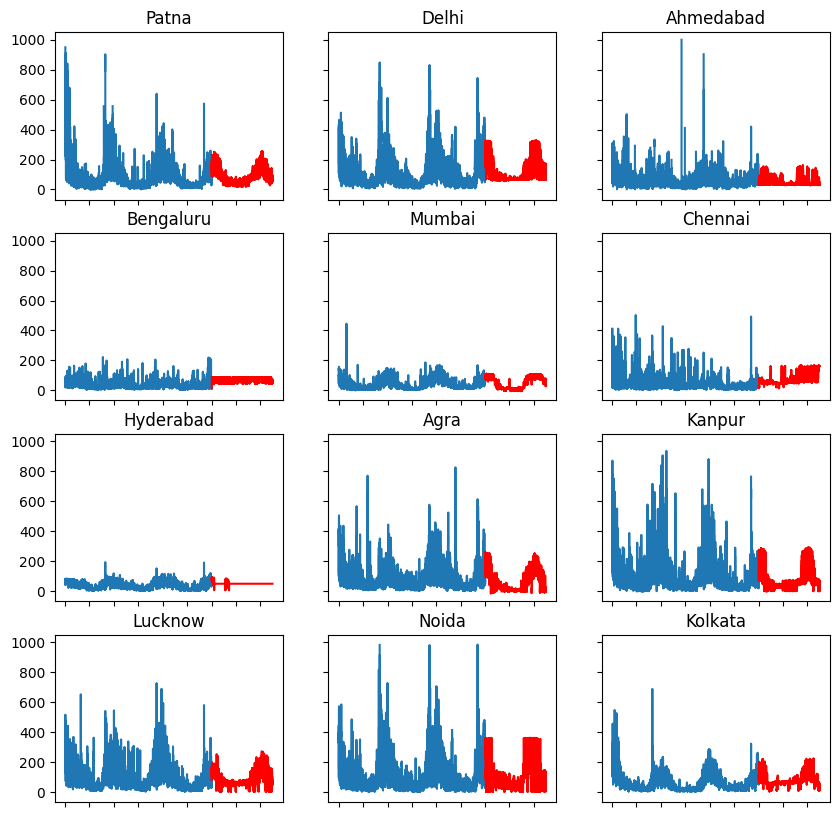

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(10,10), sharex=True, sharey=True)

dates = df_test.xs('Patna', level='city').index.get_level_values('date')

train_start_date = '2019-01-01'
idx = pd.IndexSlice
df =df.loc[idx[train_start_date:,]]

for i,city in enumerate(df_test.index.get_level_values('city').unique()):

    preds = submission.xs(city, level='city')['PM2.5']

    ax.flatten()[i].plot(df.xs(city, level='city')['PM2.5_target'])

    ax.flatten()[i].plot(dates, preds, 'red')
    ax.flatten()[i].set_title(city)
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticklabels(), rotation=45)

